# Exponential Smoothing and Innovation State Space Model (ISSM)

In this notebook we will illustrate the implementation of filtering in innovation state space model (ISSM, for short) using MXNet. Let us first briefy reivew the basic concepts.


Time series forecasting is a central problem occuring in many applications from optimal inventory management, staff scheduling to topology planning. 
Given a sequence of measurements $z_1, \ldots, z_T$ observed over time, the problem here is to predict future values of the time series $z_{T+1}, \ldots, z_{T+\tau}$, where $\tau$ is referred as the time horizon.

Exponential smoothing (ETS, which stands for *Error, Trend, and Seasonality*) is a family of very successful forecasting methods which are based on the key property that forecasts are weighted combinations of past observations ([Hyndman et. al, 2008](http://www.exponentialsmoothing.net/home)).

For example, in simple exponential smoothing, the foreacast $\hat{z}_{T+1}$ for time step $T+1$ is written as ([Hyndman, Athanasopoulos, 2012](https://www.otexts.org/fpp/7/1))

$$ \hat{z}_{T+1} = \hat{z}_T + \alpha (z_T - \hat{z}_T) = \alpha\cdot z_T + (1 - \alpha)\cdot \hat{z}_T, $$

In words, the next step forecast is a convex combination of the most recent obseravtion and forecast. Expanding the above equation, it is clear that the forecast is given by the exponentially weighted average of past observations, 

$$ \hat{z}_{T+1} = \alpha z_T + \alpha(1-\alpha) z_{T-1} + \alpha(1-\alpha)^2 z_{T-2}+ \cdots. $$

Here $\alpha > 0$ is a smoothing parameter that controls the weight given to each observation.
Note that the recent observations are given more weight than the older observations.
In fact the weight given to the past observation descreases exponentially as it gets older and hence the name **exponential smoothing**.

General exponential smoothing methods consider the extensions of simple ETS to include time series patterns such as (linear) trend, various periodic seasonal effects. All ETS methods falls under the category of forecasting methods as the predictions are point forecasts (a single value is predicted for each future time step). 
On the other hand a statistical model describes the underlying data generation process and has an advantage that it can produce an entire probability distribuiton for each of the future time steps.
Innovation state space model (ISSM) is an example of such models with considerable flexibility in respresnting commonly occurring time series patterns and underlie the exponential smoothing methods.

The idea behind ISSMs is to maintain a latent state vector $l_{t}$ with recent information about level, trend, and seasonality factors.
The state vector $l_t$ evolves over time adding small *innvoation* (i.e., the Gaussian noise) at each time step. 
The observations are then a linear combination of the components of the current state.

Mathematically, ISSM is specified by two equations

* The state transition equation is given by 

$$l_{t} = F_t l_{t-1} + g_{t}\epsilon_t,\quad \epsilon_t\sim \mathcal{N}(0,1).$$

Note that the innovation strength is controlled by $g_t$, i.e., $g_t\epsilon_t \sim \mathcal{N}(0, g_t^2)$.

* The observation equation is given by

$$z_t = a_{t}^{\top}l_{t-1} + b_t + \nu_t, \quad \nu_t \sim \mathcal{N}(0, \sigma_t^2)$$

Note that here we allow for an additional term $b_t$ which can model any determinstic component (exogenous variables).

This describes a fairy generic model allowing the user to encode specific time series patterns using the coefficients $F$, $a_t$ and thus are problem dependent. The innovation vector $g_t$ comes in terms of parameters to be learned (the innovation strengths). Moreover, the initial state $l_0$ has to be specified. 
We do so by specifying a Gaussian prior distribution $P(l_0)$, whose parameters (means, standard deviation) are learned from data as well.

The parameters of the ISSM are typically learned using the maximum likelihood principle. 
This requires the computation of the log-likelihood of the given observations i.e., computing the probability of the data under the model, $P(z_1, \ldots, z_T)$. Fortunately, in the previous notebook, we have learned how to compute the log-likelihood as a byproduct of LDS filtering problem. 


# Filtering

We remark that ISSM is a special case of linear dynamical system except that the coefficients are allowed to change over time. The filtering equations for ISSM can readily be obtained from the general derivation described in LDS.


Note the change in the notation in the following equations for filtered mean ($\mu_t$) and filtered variance ($S_t$) because of the conflict of notation for the ISSM coefficient $F$. Also note that the deterministic part $b_t$ needs to be subtracted from the observations $[z_t]$. 

$$\mu_h = F_t \mu_{t-1} \quad \quad \quad \mu_v = a_t^{\top}\mu_h$$

$$\Sigma_{hh} = F_t S_{t-1}F_t^T + g_t g_t^T \quad \quad \quad \sigma^2_{v} = a_t^T\Sigma_{hh}a_t + \sigma_t^2$$

$$K_t = \frac{1} {\sigma^2_{v}} \Sigma_{hh}a_t $$

$$\mu_t = \mu_h + K(z_t - b_t -\mu_v) \quad \quad \quad S_t = (I - K_t a_t^T)\Sigma_{hh}(I-K_t a_t^T)^T +  \sigma^2_t K_tK_t^T$$





In [1]:
import mxnet as mx
from mxnet.ndarray import linalg_gemm2 as gemm2
import mxnet.ndarray as nd

## ISSM Filtering Function

In [2]:
def ISSM_filter(z, b, F, a, g, sigma, m_prior, S_prior): 
    
    H = F.shape[0] # dim of latent state
    T = z.shape[0] # num of observations
    
    eye_h = nd.array(np.eye(H))    

    mu_seq = []
    S_seq = []
    log_p_seq = []
        
    for t in range(T):
    
        if t == 0:
            # At the first time step, use the prior
            mu_h = m_prior
            S_hh = S_prior
        else:
            # Otherwise compute using update eqns.
            F_t = F[:, :, t]            
            g_t = g[:, t].reshape((H,1))    
            
            mu_h = gemm2(F_t, mu_t)
            S_hh = gemm2(F_t, gemm2(S_t, F_t, transpose_b=1)) + \
                   gemm2(g_t, g_t, transpose_b=1)

        a_t = a[:, t].reshape((H,1))
        mu_v = gemm2(mu_h, a_t, transpose_a=1)

        # Compute the Kalman gain (vector)
        S_hh_x_a_t = gemm2(S_hh, a_t)
        
        sigma_t = sigma[t]
        S_vv = gemm2(a_t, S_hh_x_a_t, transpose_a=1) + nd.square(sigma_t)
        kalman_gain = nd.broadcast_div(S_hh_x_a_t, S_vv)

        # Compute the error (delta)
        delta = z[t] - b[t] - mu_v

        # Filtered estimates
        mu_t = mu_h + gemm2(kalman_gain, delta)

        # Joseph's symmetrized update for covariance:
        ImKa = nd.broadcast_sub(eye_h, gemm2(kalman_gain, a_t, transpose_b=1))
        S_t = gemm2(gemm2(ImKa, S_hh), ImKa, transpose_b=1) + \
                nd.broadcast_mul(gemm2(kalman_gain, kalman_gain, transpose_b=1), nd.square(sigma_t))
                
        # likelihood term
        log_p = (-0.5 * (delta * delta / S_vv
                         + np.log(2.0 * np.pi)
                         + nd.log(S_vv))
                 )

        mu_seq.append(mu_t)
        S_seq.append(S_t)
        log_p_seq.append(log_p)


    return mu_seq, S_seq, log_p_seq

## Data

We will use the [10 year US Government Bond Yields dataset](https://datahub.io/core/bond-yields-us-10y) to illustrate two specific instances of ISSM models.

In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 5)

In [4]:
df = pd.read_csv("https://datahub.io/core/bond-yields-us-10y/r/monthly.csv", header=0)

In [5]:
df.set_index("Date")

# get the time series 
ts = df.values[:,1]

# Let us normalize the time series
ts = np.array((ts - np.mean(ts)) / np.std(ts), dtype=np.double)

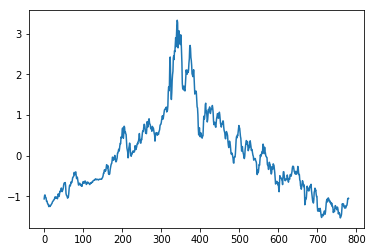

In [6]:
plt.plot(ts);

## Level ISSM

The simplest possible ISSM maintains a level component only. Abusing the notation and let $l_t$ denote *level*, the level ISSM can be written as

$$
\begin{split}
l_t = \delta l_{t-1} + \alpha \epsilon_t.
\end{split}
$$

Or in ISSM terminology, 
$$
  a_{t} = [ \delta ],\quad F_{t} = [ \delta ],\quad g_{t} = [ \alpha ],\quad \alpha>0.
$$

The level $l_t \in \mathbb{R}$ evolves over time by adding a random innovation $\alpha \epsilon_t \sim \mathcal{N}(0,\alpha^2)$ to the previous level, so that $\alpha$ specifies the amount of level drift over time. At time $t$, the previous level $l_{t-1}$ is used in the prediction $z_t$ and then the level is updated. 
The damping factor $\delta \in (0, 1]$ allows the ``damping'' of the level.
The initial state prior $P(l_0)$ is given by $l_0 \sim N(\mu_0, \sigma_0^2)$. For Level-ISSM, we learn the parameters $\alpha>0$, $\mu_0$, $\sigma_0>0$.


Here we will fix the parameters for the illustration of filtering.
Learning of the parameters will be discussed in another notebook.

In [7]:
latent_dim = 1
T          = len(ts)

# Set the coefficients of the ISSM
delta      = 1.0
F          = delta * nd.ones((1, 1, T))
a          = delta * nd.ones((1, T))

# Set the parameters of the ISSM
alpha      = 0.5
g          = alpha * nd.ones((1, T))

m_prior    = nd.zeros((latent_dim, 1))
S_prior    = nd.zeros((latent_dim, latent_dim))
sigma      = 0.5 * nd.ones((T, 1))
b          = nd.zeros((T, 1))
z          = nd.array(ts).reshape((T, 1))

In [8]:
mu_seq, S_seq, _ = ISSM_filter(z, b, F, a, g, sigma, m_prior, S_prior)

### Calculate the filtered mean and variance of observations


Given $p(l_{t-1}|z_{1:t})=\mathcal{N}(\mu_t, S_t)$, we can compute the distribution of the reconstructed observations 

$$
p(\widehat{z_t}) = \mathcal{N}(a_t^T\mu_t, a_t^TS_ta_t + \sigma_t^2).
$$

In [9]:
from functools import reduce

def reconstruct(mu_seq, S_seq):
    a_np = a.asnumpy()
    T = len(mu_seq)
    sigma_np = sigma.asnumpy()
    
    v_filtered_mean = np.array([a_np[:, t].dot(mu_t.asnumpy()) 
                                for t, mu_t in enumerate(mu_seq)]
                              ).reshape(T, )
    
    v_filtered_std = np.sqrt(np.array([a_np[:, t].dot(S_t.asnumpy()).dot(a_np[:, t]) + 
                                       np.square(sigma_np[t]) 
                                       for t, S_t in enumerate(S_seq)]).reshape((T,)))
    
    return v_filtered_mean, v_filtered_std

In [10]:
reconst_mean, reconst_std = reconstruct(mu_seq, S_seq)

### Forecast

One advantage of the ISSM model is that one can obtain the complete probability distribution for each of the future time steps:

$$
p(\widehat{z_{T+t}}) = \mathcal{N}(a_{T+t}^T\mu_{T+t}, a_{T+t}^TS_{T+t}a_{T+t} + \sigma_{T+t}^2),\quad t > 0 \\
p(l_{T+t}) = \mathcal{N}(F\mu_{T+t-1}, FS_{T+t-1}F^T + g_{T+t} g_{T+t}^T)
$$

In [11]:
def forecast(mu_last_state, S_last_state, F, a, g, sigma, horizon):
    
    forecasts_mean = []
    forecasts_std = []
    
    mu_last_state = mu_last_state.asnumpy()
    S_last_state = S_last_state.asnumpy()
    F = F.asnumpy()
    a = a.asnumpy()
    g = g.asnumpy()
    sigma = sigma.asnumpy()
    
    for t in range(horizon):
        a_t = a[:, t]
        forecast_mean = a_t.dot(mu_last_state)[0]
        forecast_std = a_t.dot(S_last_state).dot(a_t) + np.square(sigma[t])[0]
        
        forecasts_mean.append(forecast_mean)
        forecasts_std.append(forecast_std)
                    
        mu_last_state = F[:, :, t].dot(mu_last_state)
        S_last_state = F[:, :, t].dot(S_last_state).dot(F[:, :, t].T)
        
    return np.array(forecasts_mean), np.array(forecasts_std)
        

In [12]:
# Let us use the same cofficients (constant over time) for the future as well
forecasts_mean, forecasts_std = forecast(mu_seq[-1], 
                                          S_seq[-1], 
                                          F, a, g, sigma, horizon=13)

### Plot the reconstruction as well as the forecasts

In [13]:
def plot_reconstruction_forecasts(v_filtered_mean, v_filtered_std, forecasts_mean, forecasts_std):

    plt.plot(ts, color="r")
    plt.plot(v_filtered_mean, color="b")
    T = len(v_filtered_mean)
    x = np.arange(T)
    plt.fill_between(x, v_filtered_mean-v_filtered_std, 
                     v_filtered_mean+v_filtered_std, 
                     facecolor="blue", alpha=0.2)
    
    plt.plot(np.arange(T, T+len(forecasts_mean)), forecasts_mean, color="g")
    plt.fill_between(np.arange(T, T+len(forecasts_mean)), forecasts_mean-forecasts_std, 
                     forecasts_mean+forecasts_std, 
                     facecolor="green", alpha=0.2)
    
    plt.legend(["data", "reconstruction", "forecasts"]);

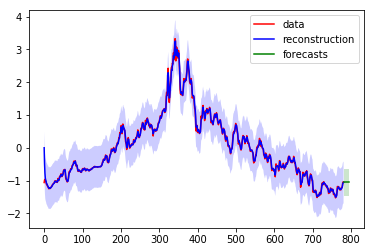

In [14]:
plot_reconstruction_forecasts(reconst_mean, reconst_std, forecasts_mean, forecasts_std)

### Level Trend ISSM

We can model a piecewise linear random process by using a two-dimensional latent state $l_{t}\in \mathbb{R}^2$, where one dimension represents the level (again with a slight abusing of notation, $l$) and the other represents the trend (slope) $b$. 

$$
\begin{split}
  l_t &= \delta l_{t - 1} + \gamma b_{t - 1} + \alpha\cdot\epsilon_t\\
  b_t &= \gamma b_{t - 1} + \beta\cdot\epsilon_t
  \end{split}
$$


In ISSM framework, such a (Damped) LevelTrend-ISSM is given by

$$
  a_{t} = \left[\begin{array}{c}
    \delta \\
    \gamma
  \end{array}\right], \quad F_{t} = \left[\begin{array}{cc}
    \delta & \gamma \\
    0 & \gamma
  \end{array}\right], \quad g_{t} = \left[\begin{array}{c}
    \alpha \\
    \beta
  \end{array}\right],
$$

where $\alpha>0$, $\beta>0$ and the damping factors $\delta, \gamma \in (0, 1]$.
Both the level and slope components evolve over time by adding innovations $\alpha \epsilon_t$ and $\beta \epsilon_t$ respectively, so that $\beta>0$ is the innovation strength for the slope. The level at time $t$ is the sum of level at $t-1$ and slope at $t-1$ (linear prediction) modulo the damping factors for level $\delta$ and growth $\gamma$.

In [15]:
latent_dim = 2
T          = len(ts)

# Set the coefficients of the ISSM
damp_fact = 1.0
damp_growth = 1.0

# Set the parameters of the ISSM
alpha      = 0.5 
beta       = 0.1 
g_t        = nd.array([alpha, beta])
g          = nd.repeat(g_t, T).reshape((latent_dim, T))

# F and a are constant over time
F_t = nd.reshape(nd.array([damp_fact, damp_growth, 0, damp_growth]), (latent_dim, latent_dim))
a_t = nd.array([damp_fact, damp_growth])
F   = nd.repeat(F_t, T).reshape((latent_dim, latent_dim, T))
a   = nd.repeat(a_t, T).reshape((latent_dim, T))

m_prior    = nd.zeros((latent_dim, 1))
S_prior    = nd.zeros((latent_dim, latent_dim))
sigma      = 0.5 * nd.ones((T, 1))
b          = nd.zeros((T, 1))
z          = nd.array(ts).reshape((T, 1))

In [16]:
mu_seq, S_seq, _ = ISSM_filter(z, b, F, a, g, sigma, m_prior, S_prior)

In [17]:
# Let us use the same cofficients (constant over time) for the future as well
forecasts_mean, forecasts_std = forecast(mu_seq[-1], 
                                          S_seq[-1], 
                                          F, a, g, sigma, horizon=13)

## Plot the reconstruction as well as the forecasts

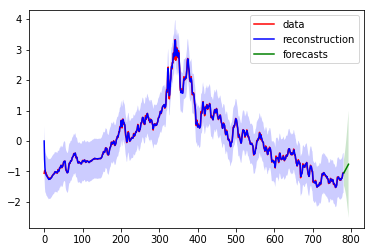

In [18]:
reconst_mean, reconst_std = reconstruct(mu_seq, S_seq)
plot_reconstruction_forecasts(reconst_mean, reconst_std, forecasts_mean, forecasts_std)